# Creating an Image Grid PDF

This notebook will outline different steps taken to create a grid of images from some labeled files. Though the project is a bit specific, you may find some useful tips to work with image files in Python.

## The Data

### Directories
The images were organized as follows:
- Three directories, each corresponding to a movie (in my case, they were Amelie, LaLaLand, and Hero).
- Each movie directory contains two directories: _jpg_ and _png_. As you may have guessed, the _png_ directory contains th same _jpg_ images without the background.


### Labelling
- Each image within a movie belongs to a category specific to the movie, which is specified in the label
- Each image has a counter
- The _png_ directory has the complete label for each image: _movie/png/movie_00000_category.png_
- The _jpg_ directory has an incomplete label for each image: _movie/jpg/movie_00000.jpg_
- For instance, _movie_00001_category.png_ is the same _movie_00001.jpg_ image without the background.

## The Task

We want, for each movie, to create a PDF file with a grid of size _n*m_, where _n_ is the total number of categories, and _m_ is the maximum number of images in a category across all categories. We may want to crop the images, as we will see later. 

In [2]:
# Importing necessary libraries we will use throughout the project
import numpy as np
from PIL import Image
import pathlib
import os
import re
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas

## Manipulating the Data

Let's begin by defining our variables and paths. `movie` will be the global variable defining the movie we will be working with

In [3]:
movies = ("amelie","lll","hero")
movie = "amelie"

We can make some sense of the categories we have in a movie by writing a command directly to the terminal

In [4]:
! ls {movie}/png | sed -E "s/{movie}_[0-9]+_(.+).png/'\1'/g" | sort -u

'color_amelie'
'color_hv'
'color_nino'
'emocion_amelie'
'emocion_hv'
'emocion_nino'
'escena1'
'escena2'
'escena3'
'escena4'
'escena5'
'escena6'
'escena7'
'lugar_apto'
'lugar_aptohv'
'lugar_cafe'
'lugar_casap'
'lugar_estaciones'
'lugar_sex'


Now, let's create a dictionary for this categories, which will be specific to each movie

In [14]:
p = pathlib.Path(f"{movie}/")
key_orders = {movie: set()}
pattern = fr"{movie}_\d+_(.*)\.[\w]+"

for image in p.rglob("png/*.png"):
    match = re.match(pattern, str(image.name))
    category = match.group(1)
    key_orders[movie].add(category)

key_orders[movie] = sorted(key_orders[movie])

We can never forget to take a look at our images, so we know what we are dealing with! I hand-picked some examples, to prove a point

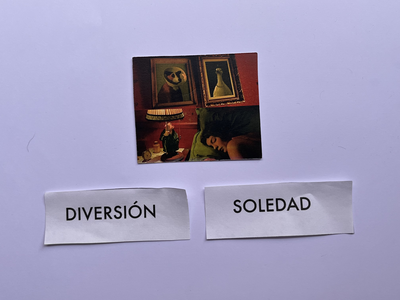

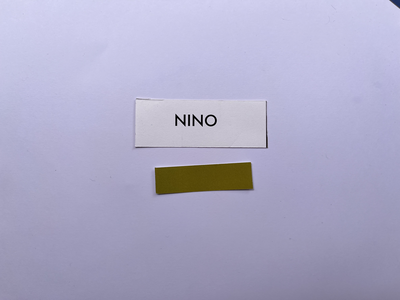

In [6]:
examples = ["amelie_00005_escena1","amelie_00008_color_nino"]
size = 400,400

for ex in examples:
    filepath = "amelie/jpg/" + ex[:12] + ".jpg"
    with Image.open(filepath) as image:
        image.thumbnail(size, Image.Resampling.LANCZOS)
        display(image)

As you can see, there is a lot of empty space (or background) in each image. Since we want to build a grid from this images, and we want to learn to work with image files in the process, let's crop the images first!

## Cropping images

This specific task required us to work with the _jpg_ files for the final grid. However, we can use the _png_ files to crop each image as much as possible, that is, eliminating as much of the background as we can for each image. 

We can define the bounding box for each image using the `getbbox` method from the `PIL` library. For this example, we want to crop the images, eliminating as much background as possible, but that will leave us with a lot of different sized images. For that reason, we will try to eliminate as much background for every category.

We can create a dictionary that stores all the bounds for every image in a category, and also the maximum bounds that a category can have.

In [17]:
bounds = {category:[[],[]] for category in key_orders[movie]}

# Storing all bounds for every image in a category in bounds[category][0]
for image in p.rglob("png/*.png"):
    match = re.match(pattern, str(image.name))
    category = match.group(1)
    img_png = Image.open(str(image))
    bounds[category][0].append(np.array(img_png.getbbox()))

# Computing the maximum bounds for a category and storing it in bounds[category][1]
for category, (im_bounds,max_bounds) in bounds.items():
    dims = np.array(im_bounds)
    min_left = dims[:, 0].min()
    min_upper = dims[:, 1].min()
    max_right = dims[:, 2].max()
    max_lower = dims[:, 3].max()
    max_bounds.extend((min_left, min_upper, max_right, max_lower))

Let's look at one category: the first element in the list contains the arrays with the bounding boxes for each image, and the second element contains the bounding box for the category.

In [18]:
bounds['color_amelie']

[[array([1187,  991, 2685, 2139]),
  array([1404, 1020, 2770, 2039]),
  array([1492,  859, 2832, 1841])],
 [1187, 859, 2832, 2139]]

Now we can crop each image in _jpg_ following the cropping bounds for each category. Since the _png_ directory is the only one containing the categories, we need to iterate over those files to crop the _jpg_ ones. In this step, we will also reduce the size of our image files.

In [19]:
cropped_dir = p.joinpath("cropped_jpg")
cropped_dir.mkdir(exist_ok=True)

for image in p.rglob("png/*.png"):
    match = re.match(pattern, str(image.name))
    category = match.group(1)
    len_fname = len(movie) + 6
    jpg_path = p.joinpath(f"jpg/{image.name[:len_fname]}.jpg")

    with Image.open(jpg_path) as img_jpg:
        img_jpg_cropped = img_jpg.crop(bounds[category][1])
        img_jpg_cropped.thumbnail(size, Image.Resampling.LANCZOS)

        # Construct the new file path using pathlib.Path
        cropped_jpg_path = cropped_dir.joinpath(image.name)

        # Save the cropped image
        img_jpg_cropped.save(cropped_jpg_path)

Now we can look at the previous examples and see how they were transformed!

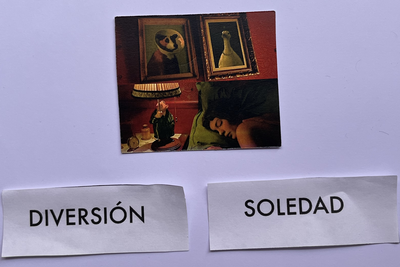

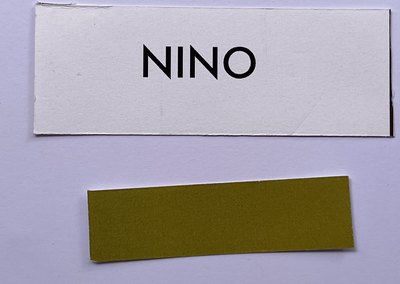

In [20]:
for ex in examples:
    filepath = "amelie/cropped_jpg/" + ex + ".png"
    with Image.open(filepath) as image:
        image.thumbnail(size, Image.Resampling.LANCZOS)
        display(image)

Much better...

## Creating an Image Grid PDF

Now we want to create a grid with our cropped images and save it as a pdf file.

In [37]:
categories = {category:[[],[]] for category in key_orders[movie]}

# Create a list of all image paths and store it in categories[category][0]
for filepath in cropped_dir.iterdir():
    match = re.match(pattern, filepath.name)
    category = match.group(1)
    categories[category][0].append(filepath)

# Store the size for each category in categories[category][1]
for category, (file_paths, sizes) in categories.items():
    first_image_path = file_paths[0]
    image = Image.open(first_image_path)
    sizes.extend(image.size)

# Store all sizes in a list for further manipulation
sizes = np.array([(categories[category][1][0],categories[category][1][1]) for category in categories.keys()])

In [38]:
# Set the number of rows and columns in the grid
columns = max(len(category[0]) for category in categories.values())
rows = len([category for category in categories.keys()])

# Set the dimensions for the images in the grid
image_width = sizes[:,0].max()
margin = 15
border_size = 3

# Calculate the PDF page size based on the grid layout and image size
page_width = (columns * image_width) + ((columns + 1) * margin) + margin
page_height = sum([categories[category][1][1] for category in categories]) + ((rows + 1) * margin) + margin

# Create a PDF document with the dynamically calculated page size
pdf = canvas.Canvas(f"{movie}/{movie}_grid.pdf", pagesize=(page_width, page_height))

# Set the x and y coordinates to position the images
x = margin
y = page_height - margin

# Iterate over the rows and columns to create the grid
for row, category in enumerate(categories.keys()):
    category_height = categories[category][1][1]
    y -= (category_height + margin)  # Update the y-coordinate for each row
    
    for col in range(columns):
        if col < len(categories[category][0]):
            image_path = str(categories[category][0][col])
            image = Image.open(image_path)
            
            # Calculate the position of the image in the grid
            image_x = x + (col * image_width) + ((col + 1) * margin)
            image_y = y
            final_width = image_width
            final_height = category_height
            
            # Draw a black border around the image
            pdf.setStrokeColorRGB(0, 0, 0)  # Set the border color to black
            pdf.setLineWidth(border_size)  # Set the border size
            pdf.rect(image_x, image_y, image_width, category_height, fill=False, stroke=True)
            
            # Add the image to the PDF
            pdf.drawInlineImage(image_path, image_x, image_y, width=final_width, height=final_height)
            
        else:
            # No image for this column and category, leave the cell empty
            pass
        
# Save the PDF file
pdf.save()
print("PDF file generated successfully.")

PDF file generated successfully.


We have successfully generated the PDF file with a grid of the images we cropped. For this example, the images were resized to fit the grid dimensions, which may add some distortion; however, that can be changed depending on your preferences.